https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/empirical-orthogonal-function-eof-analysis-and-rotated-eof-analysis

https://eprints.soton.ac.uk/143703/1/FrajkaWilliams_Rhines_dsr2010.pdf

https://datalab.marine.rutgers.edu/2020/11/introduction-to-python-data-analysis/

http://www.o3d.org/eas-6490/lectures/EOFs/eof-rotated-eof.pdf

https://www.sciencedirect.com/science/article/pii/S0967063706002160?casa_token=1ndIRqjXdjUAAAAA:m0RDPtc1HZkg27siUPFj5WAjYWAZvAfob2ztgJF4CMx0QLTrYJ_te5F00xuMhXog1kg43Y37YA#bib28

# EOF decomposition of SLA - plots

In [1]:
def plot_altim_moor_rmaps(arr, alt, glon, glat):
    # PLOTS
    cbar_range = [-.6, .6]
    cmap = cm.get_cmap('RdBu_r', 17)

    corr, pval = rmap.r_map_ts(alt.values,
                            arr.values)
    fig, ax, m = rmap.plot_corr(corr, pval, 
                            glon, glat, cbar_range, cmap)
    return ax

In [2]:
import numpy as np
from numpy import ma

import xarray as xr
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.dates as mdates

import cartopy.crs as ccrs

from palettable.cmocean.diverging import Balance_19

from eofs.xarray import Eof

import analysis_functions.aux_func as fc
import analysis_functions.aux_stereoplot as st
import analysis_functions.aux_corr_maps as rmap
import analysis_functions.aux_altimetry as altim

import gsw

In [3]:
#-------------------------------------------------------------------
# Directories
#-------------------------------------------------------------------
voldir = '/Volumes/SamT5/PhD/PhD_data/'
griddir = voldir + 'altimetry_cpom/3_dot_grid/'
topodir = voldir + 'topog/'

In [4]:
#-------------------------------------------------------------------
# bathymetry file
#-------------------------------------------------------------------
topo = xr.open_dataset(topodir + 'coarse_gebco_p5x1_latlon.nc') 
tglat, tglon = np.meshgrid(topo.lat, topo.lon)

In [5]:
#------------------------------------
# limits for mooring/altimetry data
#------------------------------------
altim_start = '2009-02-01'
altim_end = '2016-01-31'

# ALTIMETRY data
geoidtype = 'goco05c'#'eigen6s4v2' # 'goco05c', 'egm08'
satellite = 'all'
sigma = 3

# use the wrapper to detrend DOT; it returns detrended sea level anomaly (time mean removed in the de-trending)
alt = altim.detrend_dot_geosvel(geoidtype, satellite, sigma, altim_start, altim_end, plot=False)
alt_mclim = alt.groupby("time.month") - alt.groupby("time.month").mean("time")

Processing file: dot_all_30bmedian_goco05c_sig3.nc

Crop altimetry to 
 > > 2009-02-01 - 2016-01-31

>>> Computing linear trend at every grid point ..

Computing gvel .. 
Ready!


## Variable to decompose

In [6]:
alt_var = alt.sla_det

## Normal EOFs

In [7]:
# - - - - - - - - - - - - - - - - - 
# variables for EOF part 
# - - - - - - - - - - - - - - - - - 
alt_var_time = alt_var.time.dt.strftime('%m.%Y').values
alt_var_period = alt_var_time[0] + '-' + alt_var_time[-1]

aglat, aglon = np.meshgrid(alt_var.latitude.values, alt_var.longitude.values)
# - - - - - - - - - - - - - - - - -
# apply weighting to account for meridians converging at high lat
coslat = np.cos(np.deg2rad(alt_var.latitude.values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(alt_var.T, weights=wgts)

neofs = 20
eof = solver.eofsAsCovariance(neofs=neofs)
pc = solver.pcs(npcs=neofs, pcscaling=1)
variance_frac = solver.varianceFraction()

cumulative variance explained by first 3 modes:  48.90241337452761
cumulative variance explained by first 6 modes:  63.85698539873622


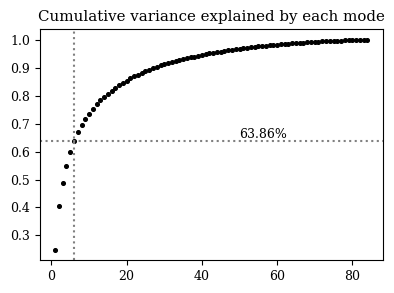

In [23]:
# - - - - - - - - - - - - - - - - -
# plot of cumulative variance for every mode 
# - - - - - - - - - - - - - - - - -
a = np.cumsum(variance_frac.values)

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(variance_frac.mode.values+1, a, s=7, c='k')
#ax.axhline(a[6], ls=':', c='grey')
#ax.axvline(7, ls=':', c='grey')
#ax.annotate('{}{}'.format(str((a[6]*100).round(2)), '%'), 
#  xy=(50, a[6]+0.01), xycoords='data')

ax.axhline(a[5], ls=':', c='grey')
ax.axvline(6, ls=':', c='grey')
ax.annotate('{}{}'.format(str((a[5]*100).round(2)), '%'), 
  xy=(50, a[5]+0.01), xycoords='data')
ax.set_title("Cumulative variance explained by each mode")
plt.tight_layout()

print("cumulative variance explained by first 3 modes: ", a[2]*1e2)
print("cumulative variance explained by first 6 modes: ", a[5]*1e2)

### EOF patterns

/Volumes/SamT5/PhD/PhD_scripts/analysis_functions/aux_stereoplot.py:71: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Volumes/SamT5/PhD/PhD_scripts/analysis_functions/aux_stereoplot.py:71: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Volumes/SamT5/PhD/PhD_scripts/analysis_functions/aux_stereoplot.py:71: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, p

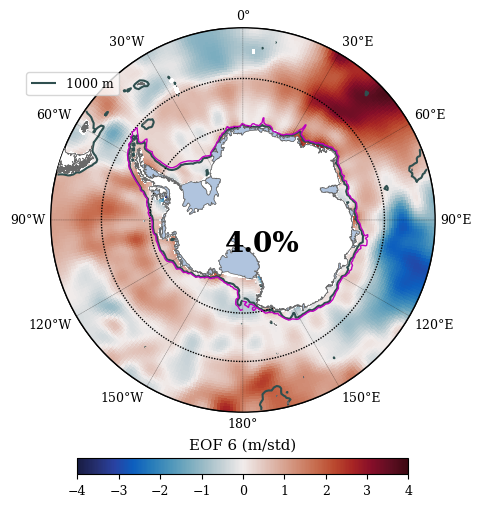

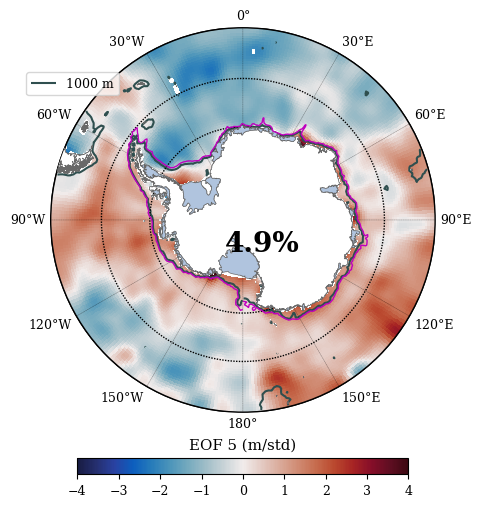

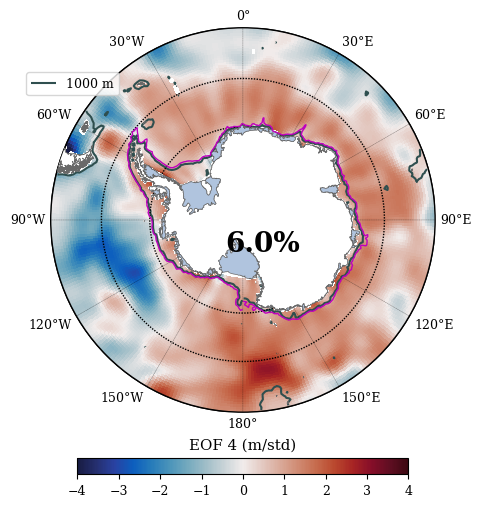

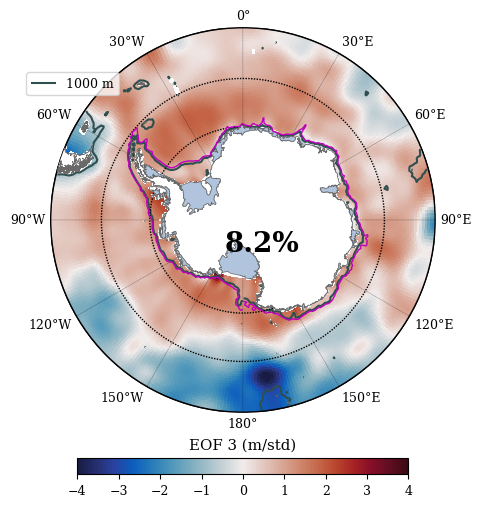

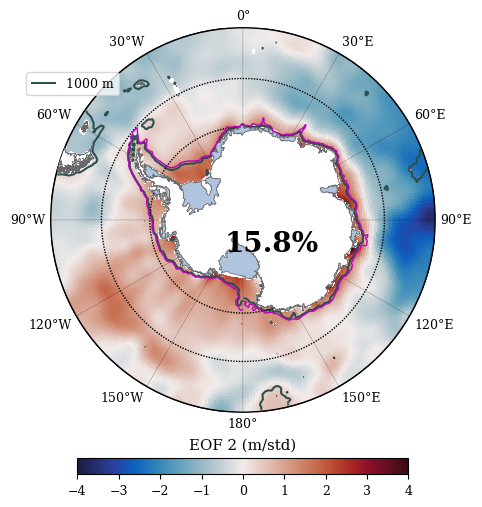

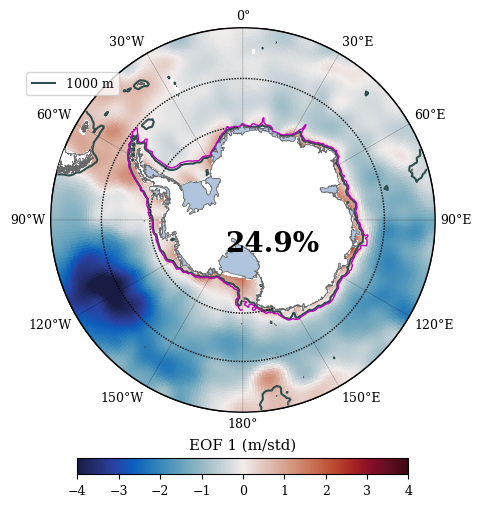

In [10]:
# >> circumpolar plots of EOF patterns
cbar_range = [-4, 4]
cmap = Balance_19.mpl_colormap

for k in range(5, -1, -1):
    cbar_units = "EOF %s (m/std)" % str(k+1)
    std_k = eof[k].std(ddof=1)

    fig, ax, m = st.spstere_plot(aglon, aglat, eof[k].values.T/std_k.values,
                                 cbar_range, cmap, cbar_units, 'm')

    lp = m.contour(tglon, tglat, topo.elevation,
          levels=[-1000],
          colors=['darkslategray'], linestyles='-',
          latlon=True, zorder=2)
    lp_labels = ['1000 m']
    for i in range(len(lp_labels)):
        lp.collections[i].set_label(lp_labels[i])
        ax.legend(loc='upper left', fontsize=9, bbox_to_anchor=(-0.08, 0.9))
        ax.annotate("{:.1%}".format(variance_frac[k].values),
                  xy=(.45, 0.5),
                  xycoords='figure fraction',
                  ha='left', va='bottom',
                  weight='bold', fontsize=20)

### Principal components

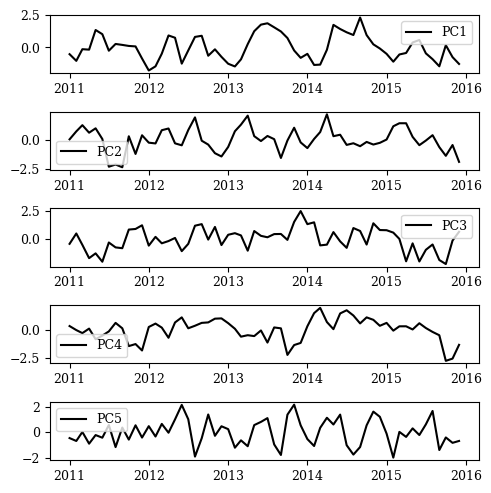

In [16]:
k = 0
fig, axs = plt.subplots(nrows=5, figsize=(5,5))
[axs[i].plot(pc.time.values, pc[:, k+i], c='k', label='PC%s'%str(i+1)) for i in range(5)]
for ax in axs[:]:
  ax.legend()
plt.tight_layout() 

## North's rule of thumb

In [11]:
eigenvals = solver.eigenvalues(neigs=neofs)
errors = solver.northTest(neigs=neofs)

<ErrorbarContainer object of 3 artists>

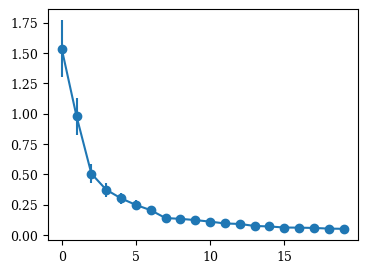

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(np.arange(neofs), eigenvals)
ax.errorbar(np.arange(neofs), eigenvals, errors)

 difference between neighbouring eigenvalues (lambda) must be greater than their associated error; when that is nto the case, the eigenvalue is mixed (degenerate)

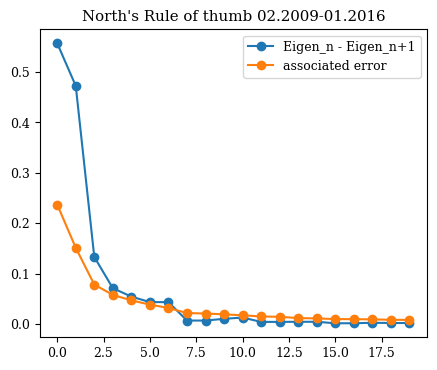

In [13]:
eg = eigenvals.data

diff1, diff2 = [0*np.ones(eg.shape) for _ in range(2)]
diff1[:-1] = abs(eg[:-1] - eg[1:])
diff2[1:] = abs(eg[1:] - eg[:-1])
diff2[0] = diff1[0]
diff1[-1] = diff2[-1]
diff_eg = np.minimum(diff1, diff2)

# associated error of neighbouring eigenvalues
err = errors.data
comb_error = np.sqrt(err[:-1]**2 + err[1:]**2)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(np.arange(neofs), diff_eg, marker='o', label='Eigen_n - Eigen_n+1')
ax.plot(np.arange(neofs), err, marker='o', label='associated error')
ax.legend()
ax.set_title("North's Rule of thumb " + alt_var_period)
plt.show()
#fig.savefig(figdir + 'nort_rule_s1_altim.png')

### Homogeneous correlation maps - normal EOFs

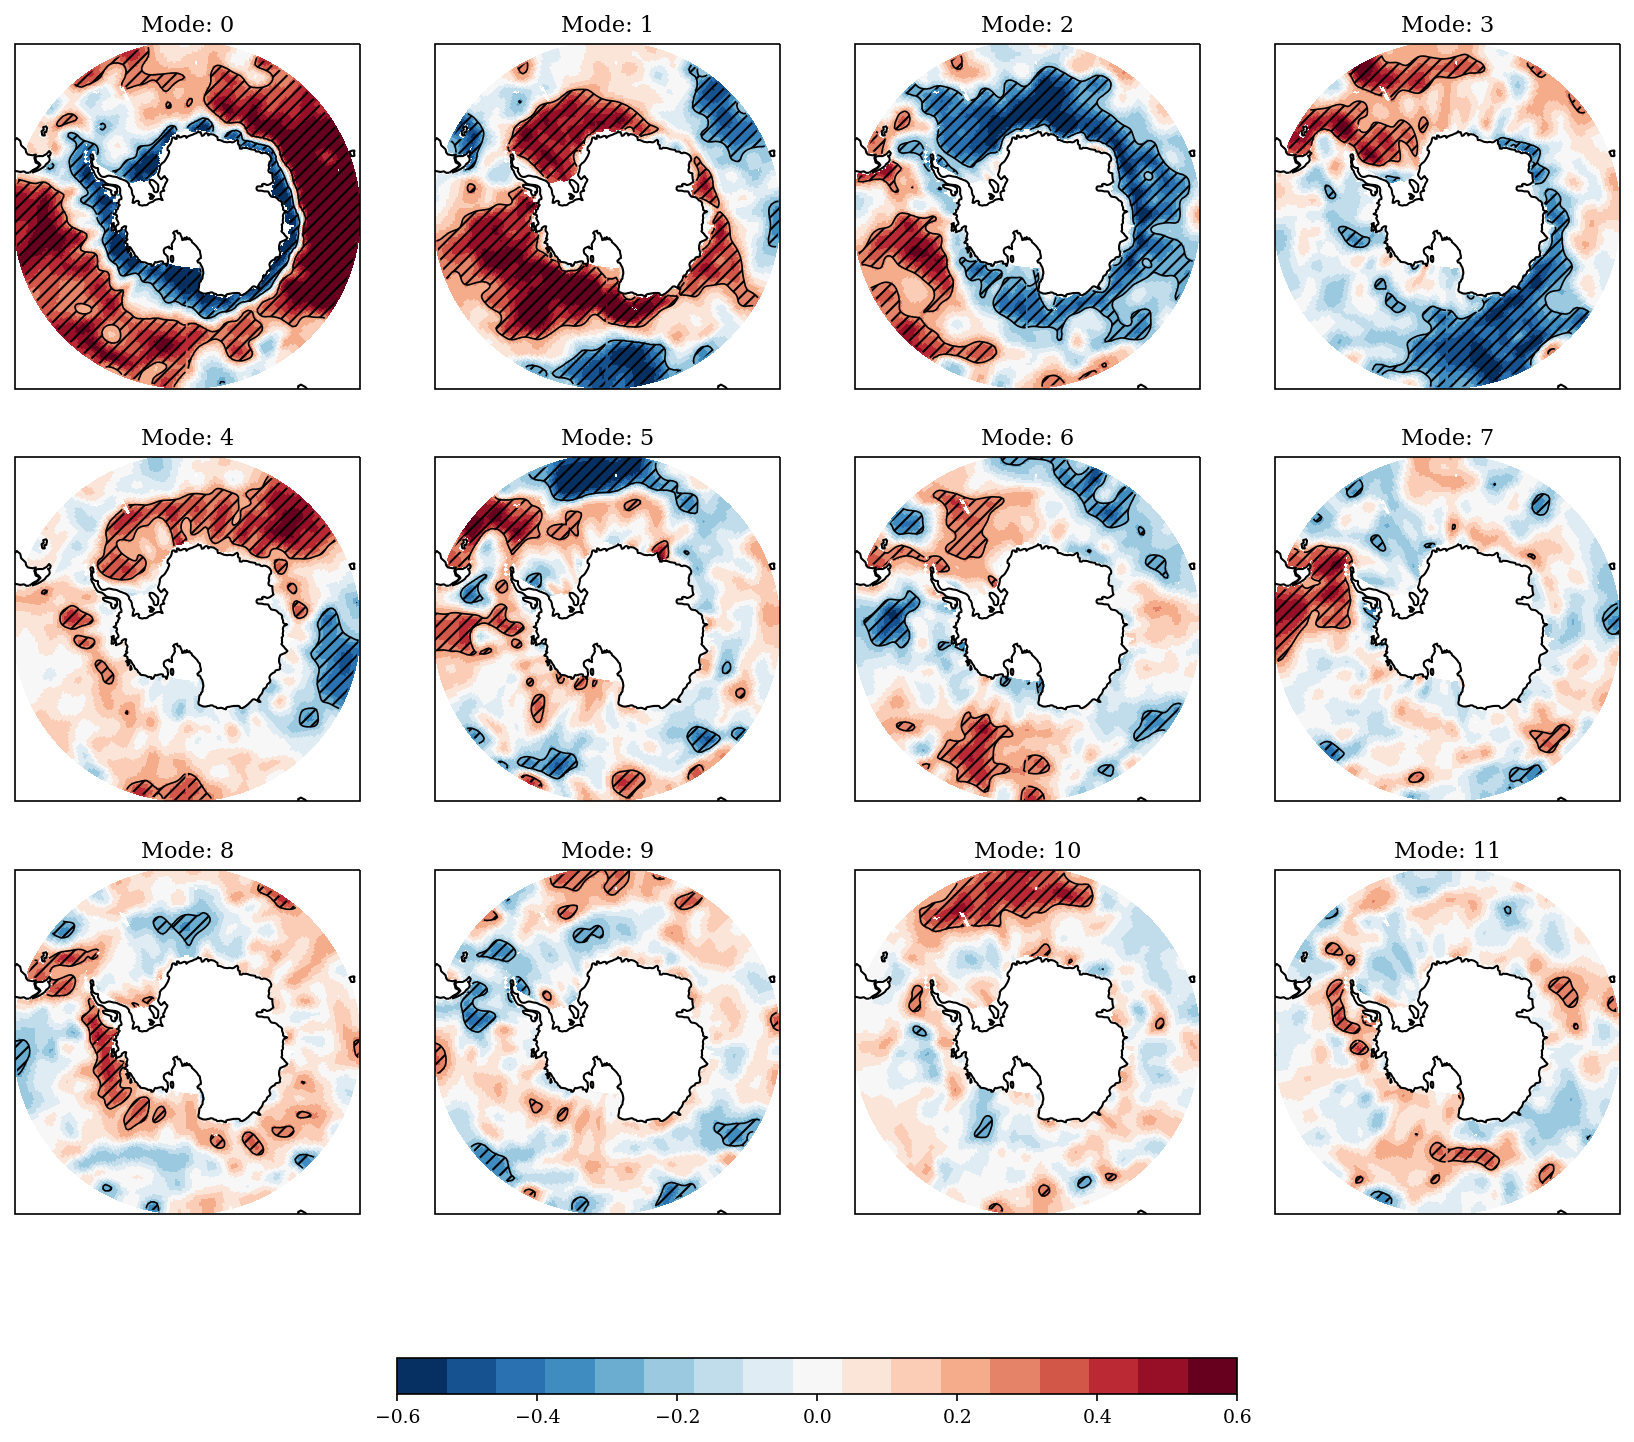

In [20]:
rec_var = alt_anom.dot_det
glon, glat = np.meshgrid(rec_var.longitude.values, rec_var.latitude.values)

nrows = 3
ncols = 4

# Define the figure and each axis for the 3 rows and 4 columns
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(14, 12), dpi=150)

# axs is a 2-dimensional array of `GeoAxes`. We will flatten it into a 1-D array
axs = axs.flatten()

cbar_range = [-0.6, 0.6]
cmap = plt.cm.get_cmap('RdBu_r', 17)

for i in range(nrows * ncols):
    if i < len(pc.mode):  # Ensure we do not exceed the number of modes
        corr, pval = rmap.r_map_ts(rec_var.values, pc.isel(mode=i).values * (-1))

        axs[i].set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())

        cs = axs[i].pcolormesh(glon.T, glat.T, corr, transform=ccrs.PlateCarree(),
                                cmap=cmap, vmin=cbar_range[0], vmax=cbar_range[1])

        axs[i].contourf(glon.T, glat.T, pval,
                       levels=[0., 0.05], colors='none',
                       hatches=['////', None], zorder=2, transform=ccrs.PlateCarree())
        axs[i].contour(glon.T, glat.T, pval,
                      levels=[0., 0.05], colors='k',
                      zorder=2, linewidths=0.8, transform=ccrs.PlateCarree())

        axs[i].set_title(f'Mode: {i}')

        # Draw the coastlines for each subplot
        axs[i].coastlines()
    else:
        axs[i].axis('off')  # Turn off the axis if there is no data to plot

# Adjust layout to prevent overlap
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0, hspace=0.2)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')

plt.show()


/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit ce

<AxesSubplot:>

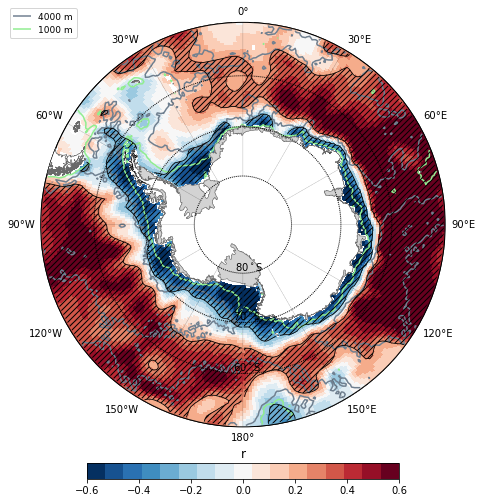

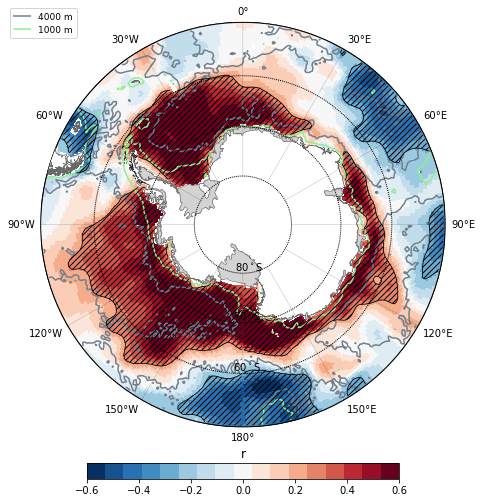

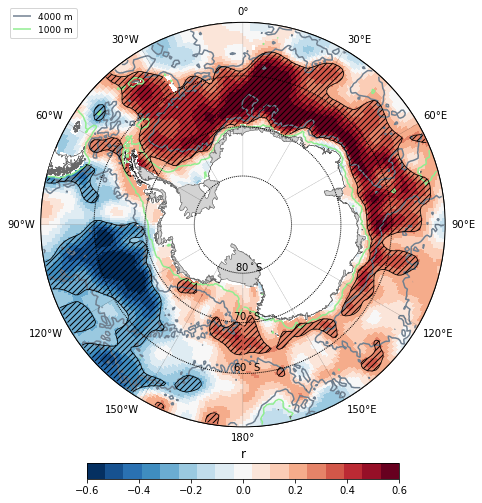

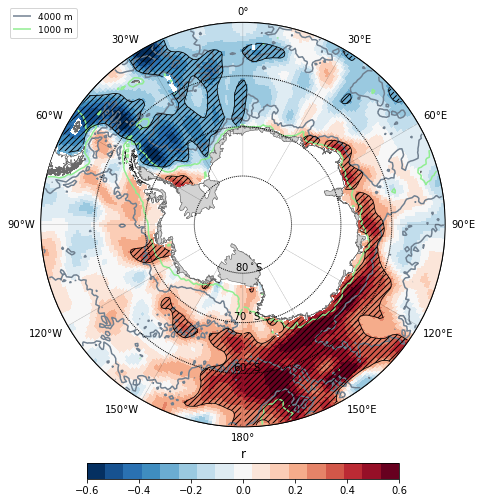

In [134]:
rec_var = alt_anom.dot

glon, glat = np.meshgrid(rec_var.longitude.values, rec_var.latitude.values)

plot_altim_moor_rmaps(pc.isel(mode=0)*(-1), rec_var, glon.T, glat.T) 
plot_altim_moor_rmaps(pc.isel(mode=1)*(-1), rec_var, glon.T, glat.T) 
plot_altim_moor_rmaps(pc.isel(mode=2)*(-1), rec_var, glon.T, glat.T)
plot_altim_moor_rmaps(pc.isel(mode=3)*(-1), rec_var, glon.T, glat.T) 

### Varimax rotation

In [19]:
from pyEOF import df_eof, get_time_space

In [119]:
# create a function for visualization convenience
def visualization(da, pcs, eofs_da, evf):
    fig = plt.figure(figsize = (10,19))

    ax = fig.add_subplot(n+1,2,1)
    da.mean(dim=["latitude","longitude"]).plot(ax=ax)
    ax.set_title("avg SLA (m)")

    ax = fig.add_subplot(n+1,2,2)
    da.mean(dim="time").plot(ax=ax)
    ax.set_title("avg SLA (m)")

    for i in range(1,n+1):
        pc_i = pcs["PC"+str(i)].to_xarray()
        eof_i = eofs_da.sel(EOF=i)["dot"]
        frac = str(np.array(evf[i-1]*100).round(2))

        ax = fig.add_subplot(n+1,2,i*2+1)
        pc_i.plot(ax=ax)
        ax.set_title("PC"+str(i)+" ("+frac+"%)")

        ax = fig.add_subplot(n+1,2,i*2+2)
        eof_i.plot(ax=ax,
                   vmin=-0.75, vmax=0.75, cmap="RdBu_r",
                   cbar_kwargs={'label': ""})
        ax.set_title("EOF"+str(i)+" ("+frac+"%)")

    plt.tight_layout()
    plt.show()

In [120]:
# set time coordinate as first dimension
da = alt_var.T

# convert DataArray to DataFrame
df = da.to_dataframe().reset_index() # get df from da
df_data = get_time_space(df, time_dim = "time", 
                         lumped_space_dims = ["latitude","longitude"])

In [63]:
df_eof?

In [121]:
n = 4
pca = df_eof(df_data, pca_type="varimax", n_components=n)

/Users/ocd1n16/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/ocd1n16/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/Users/ocd1n16/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


In [65]:
pca.eofs?

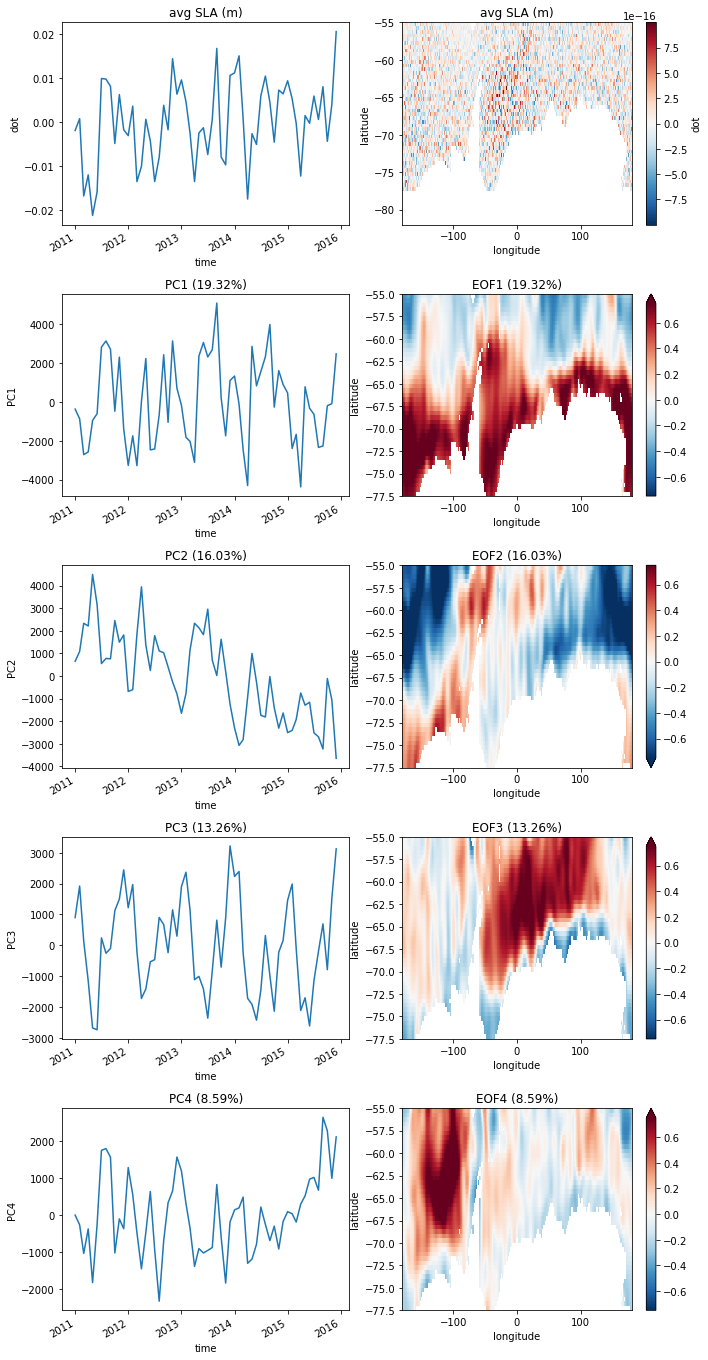

In [122]:
eofs = pca.eofs(s=2, n=n) # get eofs
eofs_da = eofs.stack(["latitude","longitude"]).to_xarray() # make it convenient for visualization
pcs = pca.pcs(s=2, n=n) # get pcs
evfs = pca.evf(n=n) # get variance fraction

pcs_da = pcs.to_xarray()

# plot
visualization(da, pcs, eofs_da, evfs)

### homogeneous correlation maps = corr between PC and the original data at each location - VARIMAX

/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit ce

<AxesSubplot:>

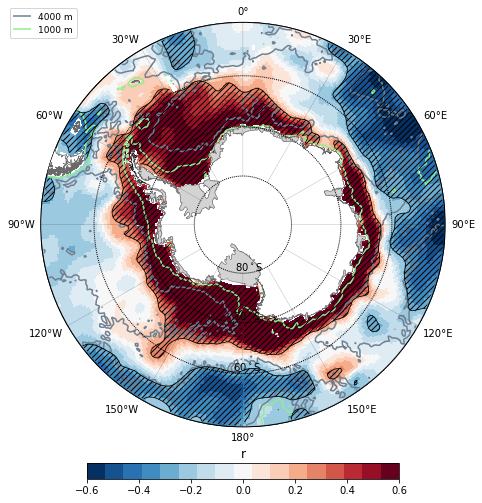

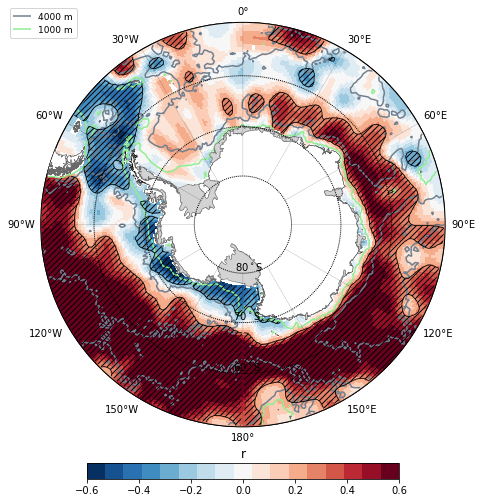

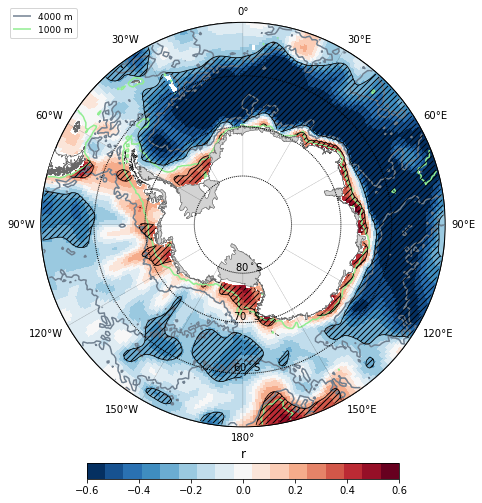

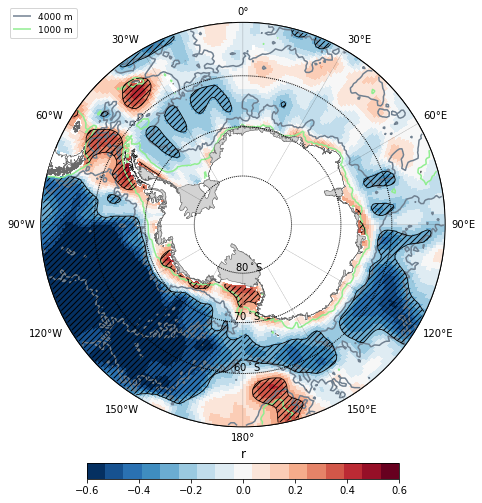

In [123]:
rec_var = alt_anom.dot

glon, glat = np.meshgrid(rec_var.longitude.values, rec_var.latitude.values)

plot_altim_moor_rmaps(pcs_da.PC1, rec_var, glon.T, glat.T) 
plot_altim_moor_rmaps(pcs_da.PC2*(-1), rec_var, glon.T, glat.T) 
plot_altim_moor_rmaps((-1)*pcs_da.PC3, rec_var, glon.T, glat.T)
plot_altim_moor_rmaps(pcs_da.PC4*(-1), rec_var, glon.T, glat.T) 

/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(varlon, varlat, var,
/Users/ocd1n16/PhD_local/scripts/aux_func/aux_stereoplot.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit ce

<AxesSubplot:>

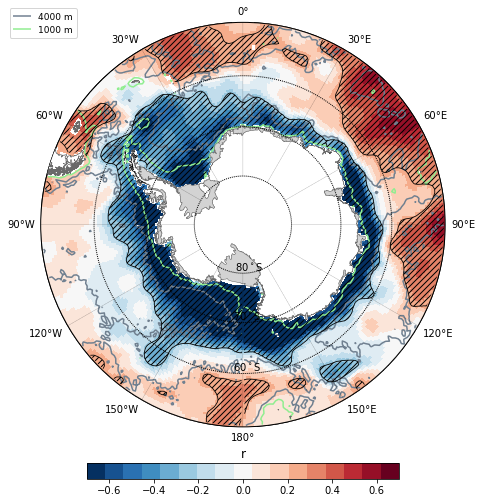

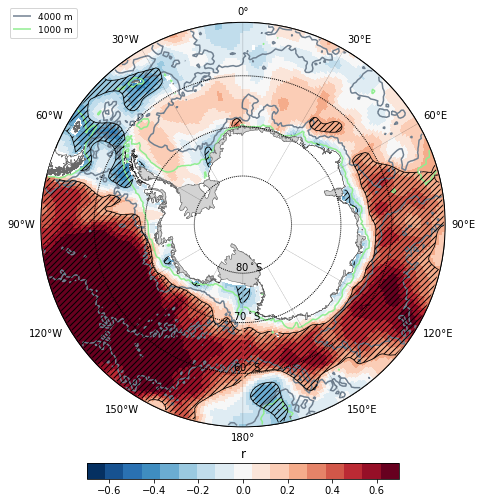

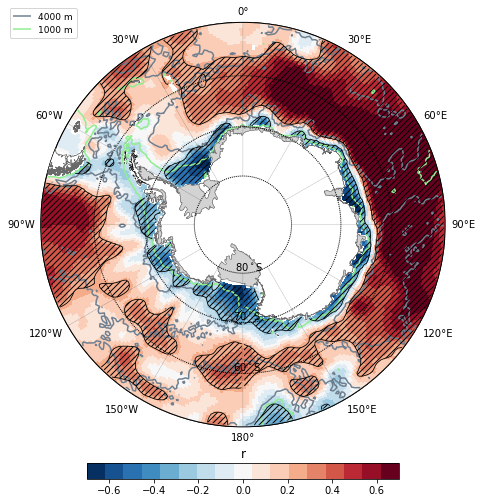

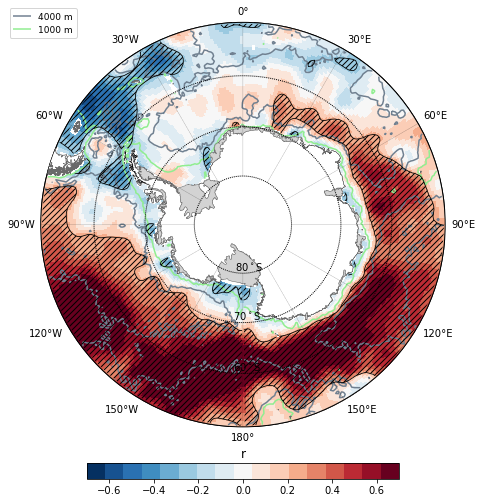

In [161]:
rec_var = alt_anom.dot_det

glon, glat = np.meshgrid(rec_var.longitude.values, rec_var.latitude.values)

plot_altim_moor_rmaps(pcs_da.PC1*(-1), rec_var, glon.T, glat.T) 
plot_altim_moor_rmaps(pcs_da.PC2, rec_var, glon.T, glat.T) 
plot_altim_moor_rmaps((-1)*pcs_da.PC3, rec_var, glon.T, glat.T)
plot_altim_moor_rmaps(pcs_da.PC4*(-1), rec_var, glon.T, glat.T) 